# Hate Speech Classification

## Introduction


This Jupyter Notebook presents a project focused on the classification of hate speech, using a dataset presumably derived from Twitter. It is an exploration into Natural Language Processing (NLP) and Machine Learning (ML), with a specific aim to identify and categorize hate speech. The project encompasses all stages of a typical data science project, starting with data loading and preprocessing, followed by exploratory data analysis, model building, and evaluation.

### Import the necessary libraries

In [49]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import pickle
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
### Read the data

In [5]:
imbalance_data = pd.read_csv("/dataset/imbalanced_data.csv")

In [6]:
imbalance_data.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


---
### EDA

<Axes: xlabel='label', ylabel='count'>

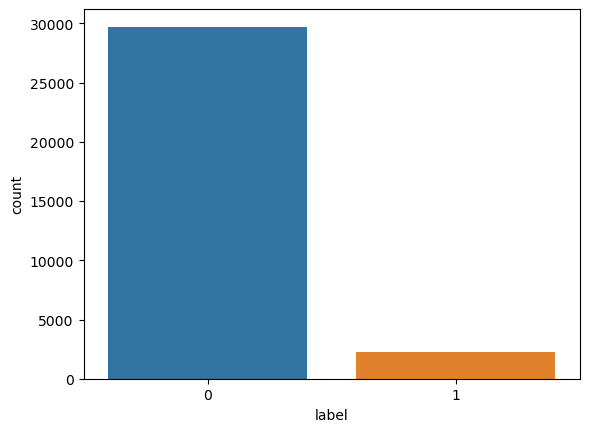

In [7]:
sns.countplot(x='label',data =imbalance_data)

From the above plot we can see that classes are imbalanced, we will fix it later.

In [8]:
# Checking the shape of the data
imbalance_data.shape

(31962, 3)

In [9]:
# Cheking if null values are present in the dataset or not.
imbalance_data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [10]:
# Let's drop the 'id' column as it is not required.
imbalance_data.drop('id',axis=1, inplace =True)

In [11]:
# Let's load another dataset similar to our dataset, since we want to fix the imbalance data.
raw_data = pd.read_csv("/dataset/raw_data.csv")

In [12]:
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [13]:
raw_data.shape

(24783, 7)

In [14]:
raw_data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [15]:
# Let's drop the columns which are not required for us.
raw_data.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace =True)

In [16]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [17]:
# Let's check for the unique values in the dataset
raw_data['class'].unique()

array([2, 1, 0])

<Axes: xlabel='class', ylabel='count'>

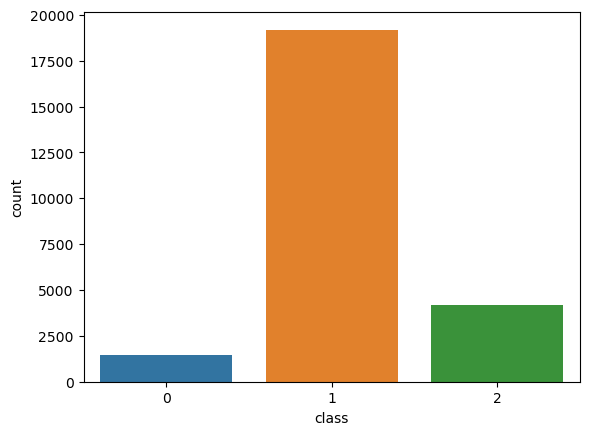

In [18]:
# Plotting the countplot for our new dataset
sns.countplot(x='class',data =raw_data)

- class 0: hate, class 1: abusive, and class 2: no hate.
- Let's copy the valus of the class 1 into class 0.

In [19]:
raw_data[raw_data['class']==0]['class']=1

/tmp/ipykernel_32/3600235578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[raw_data['class']==0]['class']=1


In [20]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [21]:
raw_data['class'].unique()

array([2, 1, 0])

In [22]:
# Let's check the values in the class 0
raw_data[raw_data['class']==0]

,class,tweet
85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer"" gaywad"
89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a beaner smh you can tell hes a mexican"
110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, blacklisted hoe"" Holding out for #TehGodClan anyway http://t.co/xUCcwoetmn"
184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPLE https://t.co/RNvD2nLCDR"" This is why there's black people and niggers"
202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http://t.co/RGJa7CfoiT""\n\nLmfao"
204,0,"""@NotoriousBM95: @_WhitePonyJr_ Ariza is a snake and a coward"" but at least he isn't a cripple like your hero Roach lmaoo"
219,0,"""@RTNBA: Drakes new shoes that will be released by Nike/Jordan.... Yes, there's glitter on the shoes http://t.co/QCtPLxHEXM"" ....dudes a fag"
260,0,"""@TheoMaxximus: #GerrysHalloweenParty http://t.co/3ycrSrnjHc"" Halloween was yesterday stupid nigger"
312,0,"""@ashlingwilde: @ItsNotAdam is bored supposed to be cute, you faggot?"" Sometimes"
315,0,"""@bigbootybishopp: @white_thunduh lassen cc , the coach wants me"" i feel it youll get more my nig no doubt"


In [23]:
# replace the value of 0 to 1
raw_data["class"].replace({0:1},inplace=True)

In [24]:
raw_data["class"].unique()

array([2, 1])

<Axes: xlabel='class', ylabel='count'>

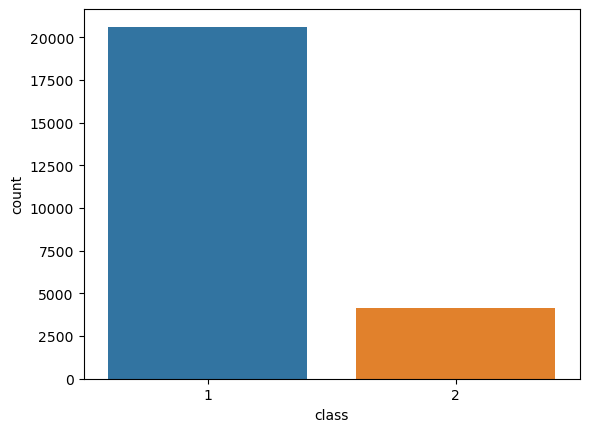

In [25]:
sns.countplot(x="class",data= raw_data)

In [26]:
# Let's replace the value of 2 to 0.
raw_data["class"].replace({2:0}, inplace = True)

<Axes: xlabel='class', ylabel='count'>

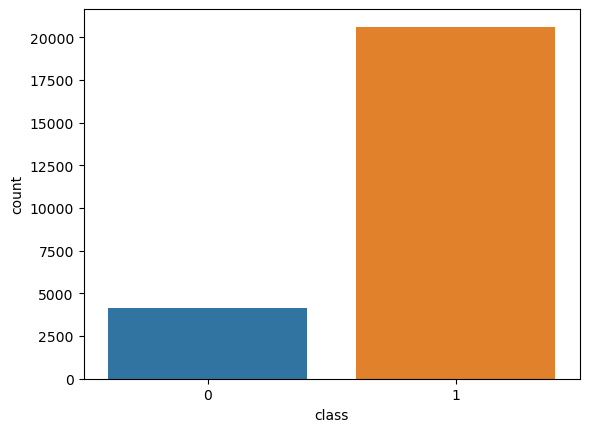

In [27]:
sns.countplot(x='class',data=raw_data)

In [28]:
# Let's change the name of the 'class' to label
raw_data.rename(columns={'class':'label'},inplace =True)

In [29]:
raw_data.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [30]:
raw_data.iloc[0]['tweet']

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [31]:
# Let's concatinate both the data into a single data frame.
frame = [imbalance_data, raw_data]
df = pd.concat(frame)

In [32]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


<Axes: xlabel='label', ylabel='count'>

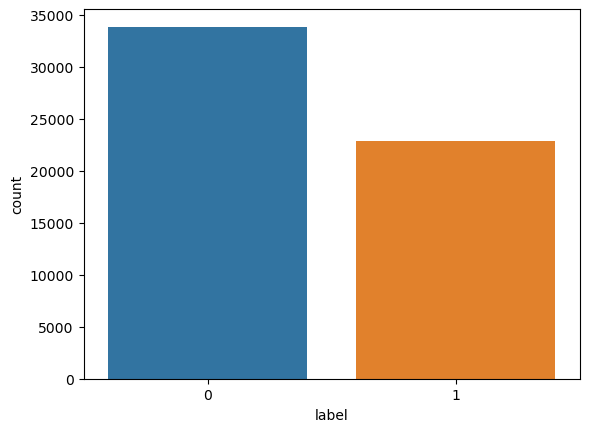

In [33]:
sns.countplot(x='label',data=df)

Now we can see that the problem of imbalace data has been solved.

In [34]:
df.shape

(56745, 2)

In [36]:
# Specify the file path where you want to save the CSV file
csv_file_path = "/kaggle/working/data.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

In [37]:
data=df

**Now, let's perform further EDA on this data. We will look at the distribution of tweet lengths, visualize the most common words, and create word clouds for each class.**

#### Distribution of Tweet Lengths
To start with, we will add a new column to the dataframe representing the length of each tweet. We will then plot histograms to visualize the distribution of tweet lengths for each class.

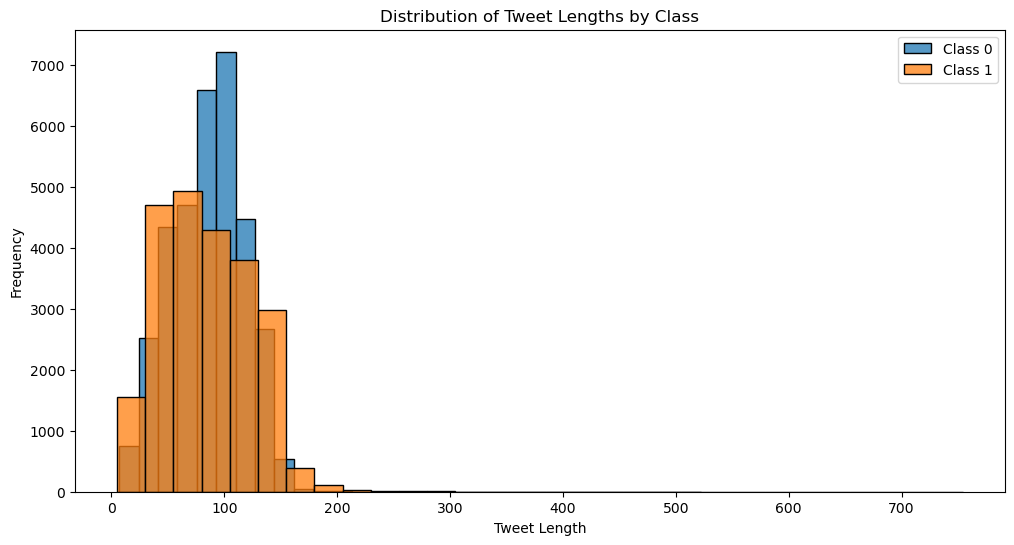

In [38]:
# Calculate tweet lengths
data['tweet_length'] = data['tweet'].apply(lambda x: len(x))

# Plot distribution of tweet lengths for each class
plt.figure(figsize=(12, 6))
for label in data['label'].unique():
    sns.histplot(data[data['label'] == label]['tweet_length'], kde=False, bins=30, label=f'Class {label}')
plt.title('Distribution of Tweet Lengths by Class')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


The histogram above displays the distribution of tweet lengths for each class in your dataset. This can provide insights into whether the length of a tweet is related to its class.

Next, let's proceed with finding the most common words in each class. For this, we'll need to tokenize the tweets, which means splitting them into individual words. We'll use the natural language toolkit (NLTK) for this task. We'll also remove stop words, which are common words like 'is', 'the', 'and', etc., that do not contain important meaning and are often removed from texts.

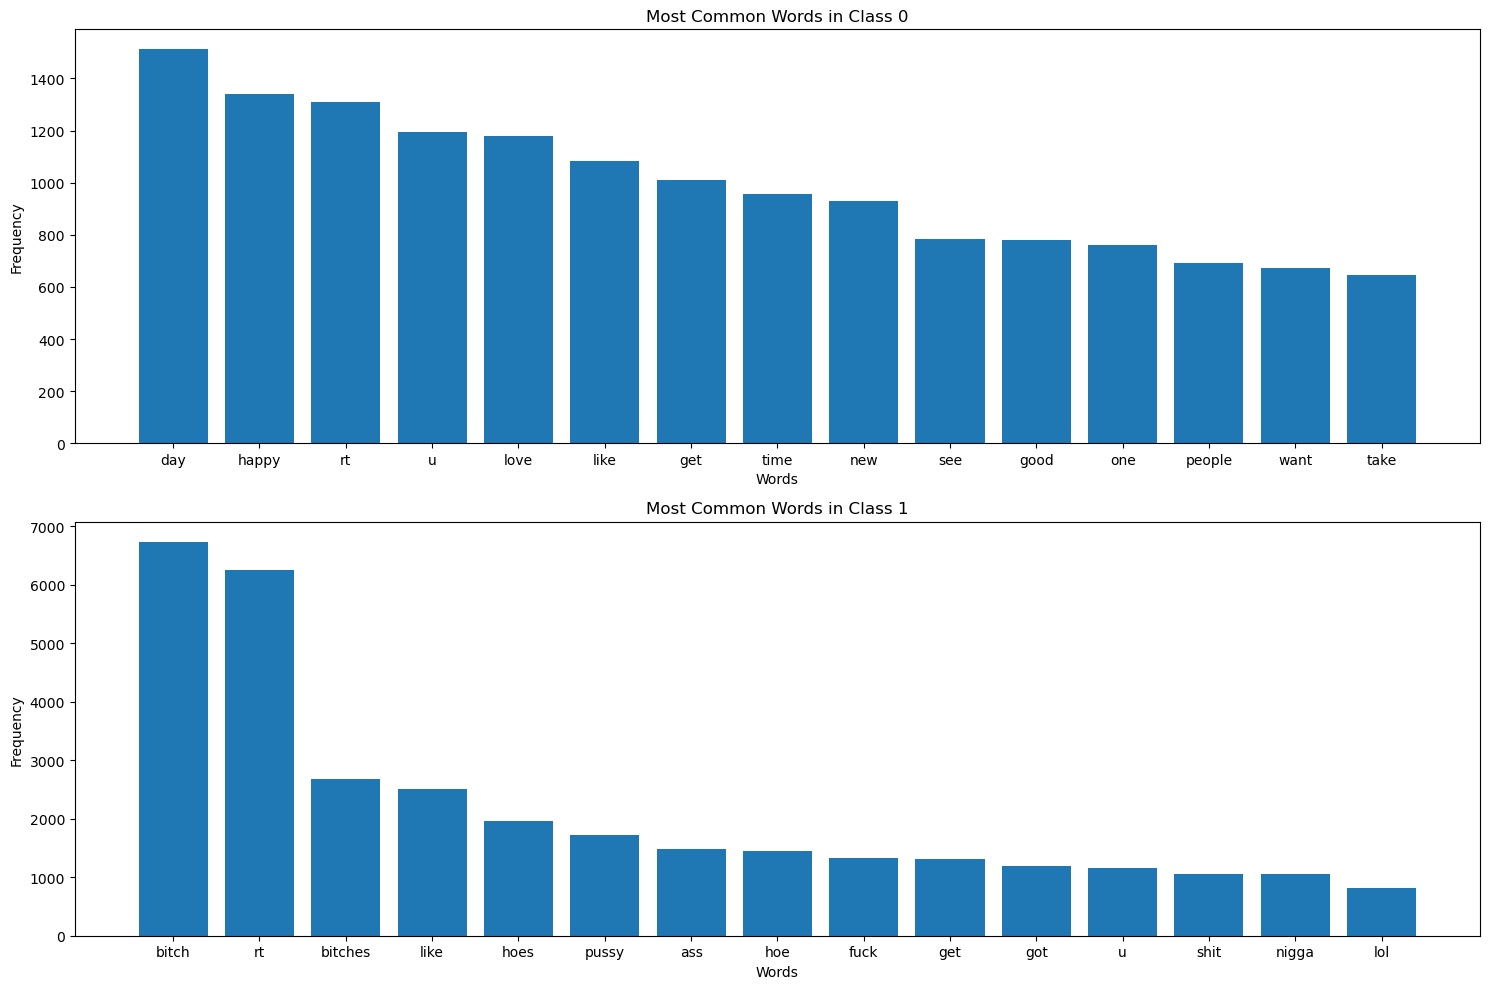

In [45]:
stop_words = set(stopwords.words('english'))
# Function to preprocess tweets
def preprocess_tweets(tweet):
    # Tokenize the tweet
    tokens = tweet.split()
    # Remove stopwords and non-alphabetic tokens
    words = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return words

# Apply the function to each tweet
data['words'] = data['tweet'].apply(preprocess_tweets)

# Calculate word frequency for each class
word_frequency = dict()
for label in data['label'].unique():
    all_words = [word for words in data[data['label'] == label]['words'] for word in words]
    word_frequency[label] = Counter(all_words)

# Plot word frequency for each class
fig, axs = plt.subplots(2, figsize=(15, 10))
for i, label in enumerate(data['label'].unique()):
    most_common_words = word_frequency[label].most_common(15)
    words = [x[0] for x in most_common_words]
    counts = [x[1] for x in most_common_words]
    axs[i].bar(words, counts)
    axs[i].set_title(f'Most Common Words in Class {label}')
    axs[i].set_xlabel('Words')
    axs[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


The bar plots above show the 15 most common words in each class of tweets, after tokenizing the tweets and removing stop words. These plots can provide insights into which words are most characteristic of each class.

Lastly, let's generate word clouds for each class. A word cloud (also known as a tag cloud) is a visualization where the size of each word indicates its frequency or importance

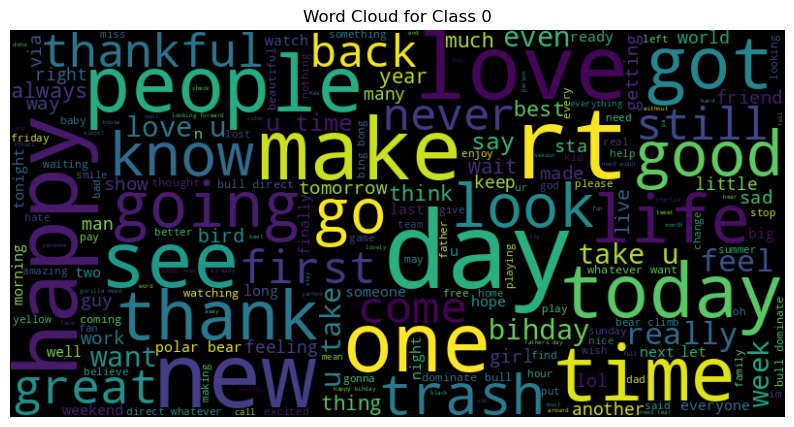

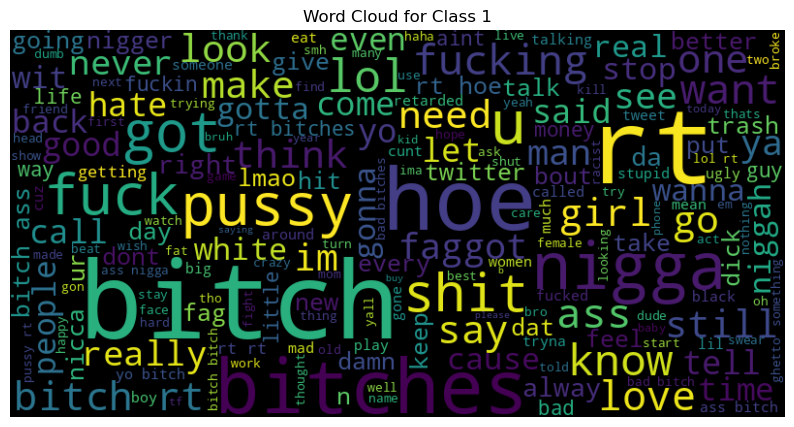

In [46]:
# Function to convert list of words into a single string
def words_to_string(words_list):
    return ' '.join(words_list)

# Convert lists of words in the 'words' column back into strings
data['words_string'] = data['words'].apply(words_to_string)

# Generate a word cloud for each class
for label in data['label'].unique():
    wordcloud_string = ' '.join(data[data['label'] == label]['words_string'])
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(wordcloud_string)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Word Cloud for Class {label}')
    plt.show()


## Modeling

In [34]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [35]:
# Let's apply regex and do cleaning. 
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [36]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [37]:
df["tweet"][3]

3    model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   mo...
3     rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cgander...
Name: tweet, dtype: object

In [38]:
df.head(10)

,label,tweet
0,0,user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run user when a father is dysfunctional and is so self...
1,0,user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthank user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthank user user thanks for lyft...
2,0,bihday your majesti bihday your majesti bihday your majesti bihday your majesti bihday your majesti
3,0,model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦ model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦ model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦ mo...
4,0,factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society ...
5,0,huge fan fare and big talking before they leave chaos and pay disputes when they get there allshowandnogo huge fan fare and big talking before they leave chaos and pay disputes when they get there allshowandnogo huge fan fare and big talking be...
6,0,user camping tomorrow user user user user user user user dannyâ¦ user camping tomorrow user user user user user user user dannyâ¦ user camping tomorrow user user user user user user user dannyâ¦ user camping tomorrow user user user user user us...
7,0,the next school year is the year for examsð¯ cant think about that ð­ school exams hate imagine actorslife revolutionschool girl the next school year is the year for examsð¯ cant think about that ð­ school exams hate imagine actorslife rev...
8,0,we won love the land allin cavs champions cleveland clevelandcavaliers â¦ we won love the land allin cavs champions cleveland clevelandcavaliers â¦ we won love the land allin cavs champions cleveland clevelandcavaliers â¦ we won love the land...
9,0,user user welcome here im its so user user welcome here im its so user user welcome here im its so user user welcome here im its so user user welcome here im its so user user welcome here im its so user...


In [39]:
x = df['tweet']
y = df['label']

In [40]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

42558 42558
14187 14187


In [41]:
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [42]:
len(x_test)

14187

In [43]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [44]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [45]:
# EarlyStopping callback to stop training if the monitored quantity does not improve
stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# ModelCheckpoint callback to save the model with the best validation accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [46]:
# starting model training
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs =5,
                   validation_split=0.2,callbacks=[stop,checkpoint])

Epoch 1/5
266/266 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.9062
Epoch 1: val_accuracy improved from -inf to 0.94020, saving model to best_model.h5
266/266 [==============================] - 336s 1s/step - loss: 0.2569 - accuracy: 0.9062 - val_loss: 0.1660 - val_accuracy: 0.9402
Epoch 2/5
266/266 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9497
Epoch 2: val_accuracy improved from 0.94020 to 0.94161, saving model to best_model.h5
266/266 [==============================] - 328s 1s/step - loss: 0.1433 - accuracy: 0.9497 - val_loss: 0.1654 - val_accuracy: 0.9416
Epoch 3/5
266/266 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9587
Epoch 3: val_accuracy improved from 0.94161 to 0.94314, saving model to best_model.h5
266/266 [==============================] - 332s 1s/step - loss: 0.1205 - accuracy: 0.9587 - val_loss: 0.1559 - val_accuracy: 0.9431
Epoch 4/5
266/266 [==============================] - ETA: 0s - l

In [47]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [48]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

444/444 [==============================] - 32s 72ms/step - loss: 0.1669 - accuracy: 0.9397


In [49]:
lstm_prediction = model.predict(test_sequences_matrix)

444/444 [==============================] - 32s 71ms/step


In [50]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)
        

In [51]:
print(confusion_matrix(y_test,res))

[[8132  321]
 [ 535 5199]]


In [52]:
# Saving the tokenizer as pickle file
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
# Let's save the model.
model.save("model.h5")

### Testing model on Custom texts

In [50]:
import keras
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [62]:

def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
def prediction_pipeline(test):
    test=[clean_text(test)]
    print(test)
    seq = load_tokenizer.texts_to_sequences(test)
    padded = pad_sequences(seq, maxlen=300)
    print(seq)
    pred = load_model.predict(padded)
    print("pred", pred)
    if pred<0.5:
        print("no hate")
    else:
        print("hate and abusive")

In [60]:
test = 'humans are idiots'
prediction_pipeline(test)

humans are idiots
humans are idiots
[[939, 1600]]
1/1 [==============================] - 0s 66ms/step
pred [[0.14641598]]
no hate


In [61]:
test = 'RT @C_G_Anderson: @viva_based she look like a bitch.'
prediction_pipeline(test)

RT @C_G_Anderson: @viva_based she look like a bitch.
rt cganderson vivabased she look like a bitch
[[12, 126, 22, 13]]
1/1 [==============================] - 0s 66ms/step
pred [[0.9758381]]
hate and abusive


## Conclusion

This notebook presented a comprehensive process for classifying hate speech from text data, which presumably originates from Twitter. With the use of various Python libraries, we preprocessed and explored the data, built and trained a machine learning model, and evaluated its performance. This project illustrates the potential of NLP in moderating and filtering online content, thereby making online spaces safer and more inclusive. Future work could include optimizing the model further, applying the model to different or larger datasets, or integrating this model into live systems to filter and moderate content in real time.